# Get and store all info from train-0.tfrecord 

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
label_mapping = pd.Series.from_csv('label_names.csv',header=0).to_dict()
n = len(label_mapping)

video_lvl_record = "train-0.tfrecord"

vid_ids = []
labels = []
labels_for_MLP = []
mean_rgb = []
mean_audio = []

textual_labels = []
textual_labels_nested = []

# i=0

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example) # get visualized TFRecord
    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    
    array = np.zeros(n)
    tmp_labels=tf_example.features.feature['labels'].int64_list.value
    tmp_labels_after_pp = []
    for x in tmp_labels:
        if x<4716:
            tmp_labels_after_pp.append(x)
    labels.append(tmp_labels_after_pp)
    array[tmp_labels]=1
    labels_for_MLP.append(array)

    label_example_textual = [label_mapping[x] for x in tmp_labels]
    textual_labels_nested.append(set(label_example_textual))
    textual_labels = textual_labels + label_example_textual
    
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)


# Get distance(1-correlation) matrix for all labels

In [27]:
def grouped_data_for(l):
    # wrap the grouped data into dataframe, since the inner is pd.Series, not what we need
    l_with_c = pd.DataFrame(
        pd.DataFrame({'label': l}).groupby('label').size().rename('n')
    ).sort_values('n', ascending=False).reset_index()
    return l_with_c

textual_labels_with_counts_all = grouped_data_for(textual_labels)
top_50_labels = list(textual_labels_with_counts_all['label'][0:50].values)

# get all unique labels
all_unique_labels = list(textual_labels_with_counts_all['label'].values)

In [135]:
K_labels = []

for i in all_unique_labels: #top_50_labels:
    row = []
    for j in all_unique_labels: #top_50_labels:
        # find all records that have label `i` in them
        i_occurs = [x for x in textual_labels_nested if i in x]
        # how often does j occur in total in them?
        j_and_i_occurs = [x for x in i_occurs if j in x]
        k = 1.0*len(j_and_i_occurs)/len(i_occurs)
        row.append(k)
    K_labels.append(row)


In [136]:
K_labels = np.array(K_labels)
K_labels = pd.DataFrame(K_labels)
K_labels.columns = all_unique_labels
K_labels.index = all_unique_labels
K_labels.head()


,Games,Vehicle,Concert,Video game,Dance,Musician,Car,Animation,Football,Food,...,Hand-to-hand combat,Grape,Green Arrow,Guitar Center,Hair coloring,Hair iron,Hair roller,Half-Life,Halo 3: ODST,Škoda Octavia
Games,1.000000,0.056995,0.000000,0.492228,0.010363,0.000000,0.036269,0.051813,0.202073,0.005181,...,0.0,0.0,0.005181,0.0,0.0,0.0,0.0,0.005181,0.005181,0.000000
Vehicle,0.076389,1.000000,0.000000,0.076389,0.000000,0.000000,0.555556,0.013889,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006944
Concert,0.000000,0.000000,1.000000,0.000000,0.078740,0.440945,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
Video game,0.871560,0.100917,0.000000,1.000000,0.000000,0.000000,0.073394,0.055046,0.018349,0.000000,...,0.0,0.0,0.009174,0.0,0.0,0.0,0.0,0.009174,0.009174,0.000000
Dance,0.024691,0.000000,0.123457,0.000000,1.000000,0.024691,0.000000,0.012346,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [137]:
K_labels_trans = K_labels.transpose()
K_labels_new = (K_labels + K_labels_trans)/2
K_labels_dist = 1-K_labels_new
K_labels_dist.head()

,Games,Vehicle,Concert,Video game,Dance,Musician,Car,Animation,Football,Food,...,Hand-to-hand combat,Grape,Green Arrow,Guitar Center,Hair coloring,Hair iron,Hair roller,Half-Life,Halo 3: ODST,Škoda Octavia
Games,0.000000,0.933308,1.000000,0.318106,0.982473,1.000000,0.938655,0.899466,0.607919,0.987205,...,1.0,1.0,0.497409,1.0,1.0,1.0,1.0,0.497409,0.497409,1.000000
Vehicle,0.933308,0.000000,1.000000,0.911347,1.000000,1.000000,0.228395,0.978130,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,0.496528
Concert,1.000000,1.000000,0.000000,1.000000,0.898902,0.433849,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000
Video game,0.318106,0.911347,1.000000,0.000000,1.000000,1.000000,0.913920,0.927701,0.975900,1.000000,...,1.0,1.0,0.495413,1.0,1.0,1.0,1.0,0.495413,0.495413,1.000000
Dance,0.982473,1.000000,0.898902,1.000000,0.000000,0.975309,1.000000,0.986364,1.000000,1.000000,...,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000


# Use linkage() and dendrogram by generating condense matrix

In [138]:
import scipy.spatial.distance as ssd
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(K_labels_dist) # condense dist matrix
distArray.shape

(444153,)

In [139]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
Z = linkage(distArray)

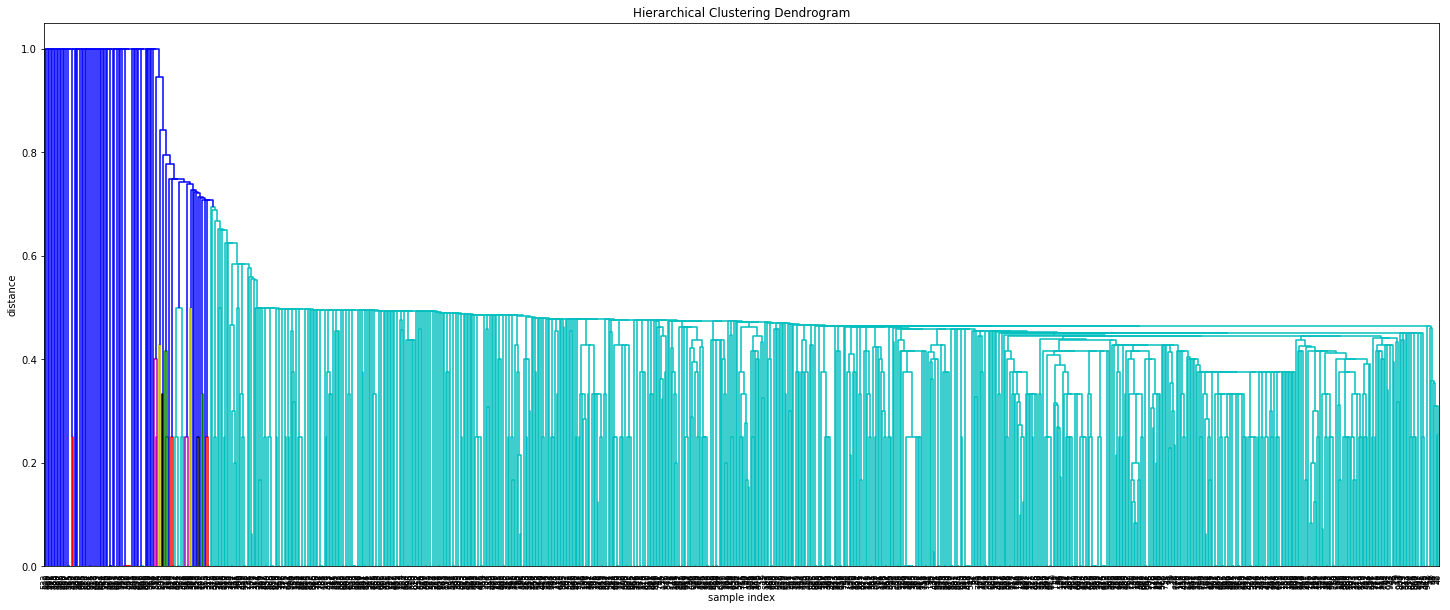

In [140]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    p=12,
    show_contracted=True,
)
plt.show()

In [93]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
#     if max_d and 'color_threshold' not in kwargs:
#         kwargs['color_threshold'] = max_d
#     annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

#     if not kwargs.get('no_plot', False):
#         plt.title('Hierarchical Clustering Dendrogram (truncated)')
#         plt.xlabel('sample index or (cluster size)')
#         plt.ylabel('distance')
#         for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
#             x = 0.5 * sum(i[1:3])
#             y = d[1]
#             if y > annotate_above:
#                 plt.plot(x, y, 'o', c=c)
#                 plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
#                              textcoords='offset points',
#                              va='top', ha='center')
    if max_d:
        plt.axhline(y=max_d, c='k')
    return ddata

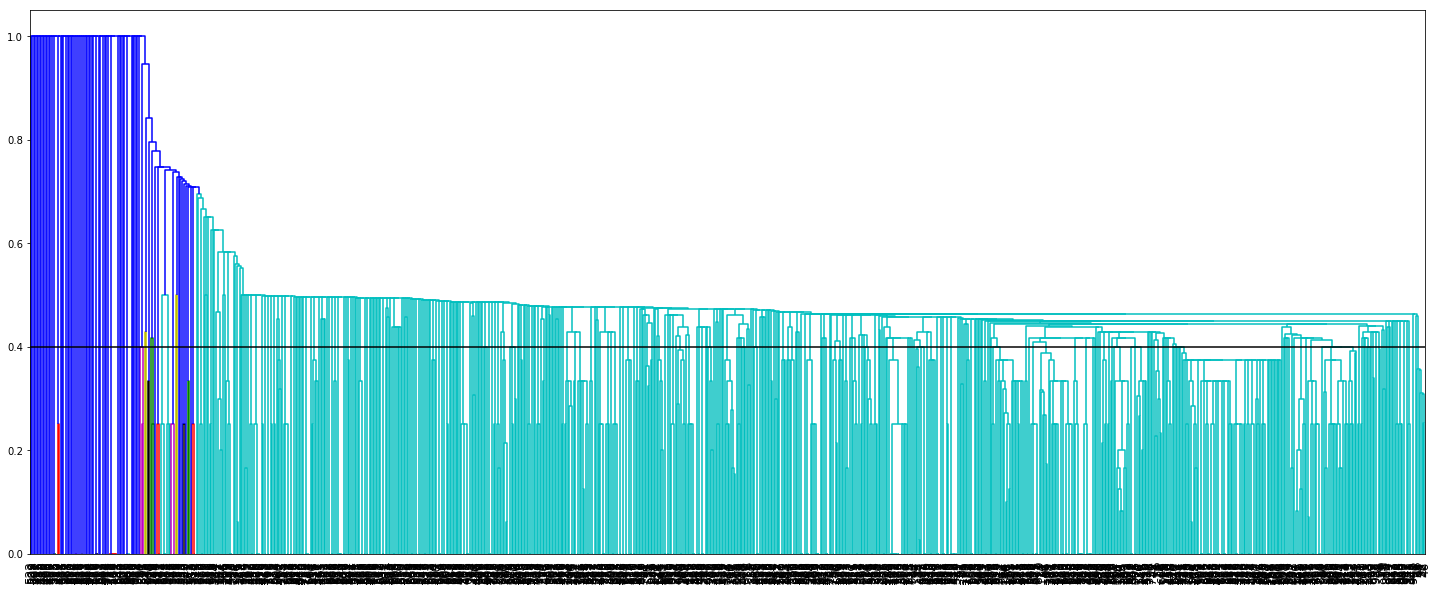

In [156]:
plt.figure(figsize=(25, 10))
max_d = 0.4
fancy_dendrogram(
    Z,
#     truncate_mode='lastp',
#     p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    max_d =max_d
#     show_contracted=True,
#     annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

# Clustering

In [221]:
from scipy.cluster.hierarchy import fcluster
# max_d=0.7
k = 650
# clusters = fcluster(Z, max_d, criterion='distance')
clusters = fcluster(Z, k, criterion='maxclust')
# clusters
numOfClusters = len(set(clusters))
numOfClusters

618

In [248]:
np.where(clusters==619)

(array([], dtype=int64),)

In [253]:
# get root node in clusters
import sys
import numpy as np

roots = np.zeros(numOfClusters)

for i in range(1, numOfClusters+1):
    tmp_cluster = np.where(clusters==i)
#     print(tmp_cluster)
    for j in tmp_cluster[0]:
        aggre_dist = 0
        min_dist = sys.float_info.max
        for k in tmp_cluster[0]:
            aggre_dist = aggre_dist + K_labels_dist.iloc[j][k]
        if(aggre_dist < min_dist):
            min_dist = aggre_dist
            roots[i-1] = j

roots

array([ 855.,  437.,  867.,  884.,  699.,  765.,  609.,  791.,  808.,
        513.,   66.,   95.,  840.,  233.,  506.,  210.,  922.,  543.,
        688.,  415.,  551.,  296.,  338.,  529.,  191.,  675.,  555.,
        916.,  259.,  381.,  639.,  347.,  144.,  234.,  305.,  366.,
        530.,  209.,  101.,  289.,  450.,  850.,  823.,  762.,  796.,
        735.,  614.,   60.,  153.,  809.,  504.,  928.,  914.,  616.,
        785.,  317.,  217.,  542.,  455.,  451.,  797.,  453.,   65.,
        888.,  665.,  206.,  879.,  843.,  676.,  157.,  644.,  494.,
        769.,  205.,  560.,  876.,  832.,    4.,  103.,  181.,  698.,
         80.,  810.,  619.,  705.,  580.,   58.,  536.,  561.,  533.,
        574.,  653.,  550.,  924.,  173.,  633.,  301.,  803.,  656.,
          7.,   16.,  204.,  343.,  385.,  546.,  151.,  920.,  783.,
        941.,  180.,  895.,  510.,  516.,  813.,  150.,  368.,  163.,
        606.,  934.,  763.,  118.,  372.,   24.,   53.,  805.,  630.,
        431.,   23.,

# Basic model

In [254]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

X = mean_audio #[[0., 0.], [1., 1.]]
y = labels_for_MLP #[[0, 1, 1], [1, 1, 0], [1, 0, 0]]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
clf.fit(X, y)                         
# clf.predict([[2., 2.], [-1., -2.]])
# clf.predict([mean_audio[8]])

a = clf.predict([mean_audio[8]])

# b = a[0]>0.15 #index 2885

print(np.nonzero(a))

(array([0, 0, 0, 0], dtype=int64), array([ 12,  26, 215, 944], dtype=int64))


# Trying to modify the prediction by adding related labels

In [329]:
b = np.nonzero(a)
# print(b[1])

res = set()
for label in b[1]:
    res.add(label)
    label_name = label_mapping[label]
    unique_idx = all_unique_labels.index(label_name)
    tmp_cluster = clusters[unique_idx]
    root_label = (int)(roots[tmp_cluster-1])
    addition_label_name = all_unique_labels[root_label]
    res.add(list(label_mapping.values()).index(addition_label_name))

for i in res:
    print(label_mapping[i])

Recipe
Garlic
Food
Hamburger
Eating
Cooking


# Result so far:

In [335]:
print('--Original labels:')

for i in labels[8]:
    print(label_mapping[i])

print()

print('--Basic model predicting labels:')

for i in b[1]:
    print(label_mapping[i])

print()

print('--Modified model predicting labels:')

for i in res:
    print(label_mapping[i])


--Original labels:
Vegetable
Hamburger
Cooking
Food
Eating

--Basic model predicting labels:
Food
Cooking
Eating
Hamburger

--Modified model predicting labels:
Recipe
Garlic
Food
Hamburger
Eating
Cooking
